In [1]:
import pandas as pd
import re

In [2]:
df = pd.read_json('../data/posts_preprocessed.json')

In [3]:
posts = df.prep_body.values.tolist()

In [4]:
# removing some last minute stop phrases
stops = [" want "," would "," make "," know ","show contact info",
         " get ","contact info", " go ", " someth ",
         " sound "," musician "," let "," like ", " also "]
for stop in stops:
    posts = [ re.sub(stop,'',x) for x in posts ]

## TF-IDF Vectorizer

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

In [6]:
ngrams = (1,2)

vectorizer = TfidfVectorizer(ngram_range=ngrams,max_df=.4)

vectorizer.fit(posts)
x = vectorizer.transform(posts)
x.shape

(18366, 586407)

## NMF Topic Model

In [7]:
no_topics = 18
# lda = LatentDirichletAllocation(n_topics=no_topics).fit(x)
nmf = NMF(n_components=no_topics).fit(x)

In [8]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print("\n".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print('\n')

### Topics by top words

In [9]:
no_top_words = 10
feature_names = vectorizer.get_feature_names()
display_topics(nmf, feature_names, no_top_words)

Topic 0:
song
re
ve
write
need
work
time
someon
peopl
good


Topic 1:
record
studio
record studio
produc
engin
session
artist
hr
pro
product


Topic 2:
lesson
teach
student
piano
teacher
learn
drum
guitar lesson
guitar
voic


Topic 3:
bass player
bass
player
player look
look bass
player avail
need bass
need
player need
player drummer


Topic 4:
drummer
drummer look
drummer avail
look drummer
drum
avail
drummer need
need
need drummer
gig


Topic 5:
event
parti
wed
jazz
avail
perform
corpor
privat
special
dj


Topic 6:
guitarist
metal
bassist
punk
metal band
influenc
guitarist look
vocalist
start
lead guitarist


Topic 7:
rehears
space
room
rehears space
studio
month
hour
practic
avail
rehears studio


Topic 8:
de
para
en
la
que
con
el
lo
un
clase


Topic 9:
cover
cover band
gig
work
pro
lead
vocal
must
tribut
gear


Topic 10:
call inform
text call
text
inform
afford price
us
call
afford
contact us
quick turnaround


Topic 11:
mix
master
mix master
audio
engin
song
servic
track
product
r

### Topic exploration

In [10]:
import numpy as np

In [11]:
topics_matrix = nmf.transform(x)

In [12]:
def explorer(tm, topic_num, posts):    
    indices = np.argsort(tm[:,topic_num])
    # get top "posts" most probabilistic posts in this topic
    top_indices = indices[len(indices):len(indices)-posts-1:-1]
    for rank, idx in enumerate(top_indices):
        print("POST RANK: ", rank+1)
        print("POST PROB: ", topics_matrix[idx,topic_num])
        print("URL: ",df.url.iloc[idx])
        print("POST CONTENT: ", '\n', df.body.iloc[idx], '\n')
        print("---------------------------------------", '\n')

In [133]:
topic_descriptions = {
    0 : "New\nMusic\nProjects",
    1 : "Studio\nServices",
    2 : "Teachers",
    3 : "Bassists",
    4 : "Drummers",
    5 : "Music\nfor\nYour\nEvent!",
    6 : "Metalheads",
    7 : "Rehearsal\nSpaces",
    8 : "En Espanol",
    9 : "Cover\nBands",
    10: "Producer/ \nGhostwriter\nAd Spam",
    11: "Mixing and\nMastering",
    12: "Guitarists",
    13: "Classic Rock",
    14: "Church",
    15: "Music \nVideos",
    16: "Singer/ \nSongwriters",
    17: "Open Mics\nand Jams"
}

In [16]:
explorer(topics_matrix, 10, 10)

POST RANK:  1
POST PROB:  0.230082723671
URL:  https://boston.craigslist.org/nwb/muc/d/how-to-get-the-best-out-of/6360131151.html
POST CONTENT:  
 How to get the BEST out of YOUR custom music 
always use a professional to get the best out of anything! custom music isn't any different. with our experience and professionals, we shall guarantee that you get the best out of your song! for affordable prices and a quick turnaround time contact us.
watch this video https://www.youtube.com/watch?v=wmnauisgfza&t=13s
text or call 
 show contact info
 for more information! please visit http://www.producemytunes.com to view our work and videos. 
our headquarters are located in atlanta but work over the net and cities all over the us! questions? contact us and see how! 

--------------------------------------- 

POST RANK:  2
POST PROB:  0.224967199016
URL:  https://houston.craigslist.org/muc/d/quality-guaranteed-for-your/6324315870.html
POST CONTENT:  
 Quality guaranteed for YOUR next custom musi

In [ ]:
import pickle 
pkg = [nmf.components_, topics_matrix]
with open("./models/nmf.pkl", "wb") as f:
    pickle.dump(pkg, f)

## t-SNE Visualization

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

In [18]:
threshold = 0.02
_idx = np.amax(topics_matrix, axis=1) > threshold  # idx of doc that above the threshold
topics_matrix_filtered = topics_matrix[_idx]

In [19]:
topics_matrix.shape

(18366, 18)

In [20]:
topics_matrix_filtered.shape

(14942, 18)

In [21]:
topics_matrix_std = StandardScaler().fit_transform(topics_matrix_filtered)

In [22]:
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.6, init='pca')
topics_mapped_2d = tsne.fit_transform(topics_matrix_std)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14942 samples in 0.360s...
[t-SNE] Computed neighbors for 14942 samples in 10.897s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14942
[t-SNE] Computed conditional probabilities for sample 2000 / 14942
[t-SNE] Computed conditional probabilities for sample 3000 / 14942
[t-SNE] Computed conditional probabilities for sample 4000 / 14942
[t-SNE] Computed conditional probabilities for sample 5000 / 14942
[t-SNE] Computed conditional probabilities for sample 6000 / 14942
[t-SNE] Computed conditional probabilities for sample 7000 / 14942
[t-SNE] Computed conditional probabilities for sample 8000 / 14942
[t-SNE] Computed conditional probabilities for sample 9000 / 14942
[t-SNE] Computed conditional probabilities for sample 10000 / 14942
[t-SNE] Computed conditional probabilities for sample 11000 / 14942
[t-SNE] Computed conditional probabilities for sample 12000 / 14942
[t-SNE] Computed conditional probabilities for sa

In [23]:
# FILTERED topic with highest NMF value for each post
max_topic_per_post = []
for i in range(topics_matrix_filtered.shape[0]):
    max_topic_per_post += topics_matrix_filtered[i].argmax(),

In [24]:
# UNFILTERED topic with highest NMF value for each post
max_topic_per_post_df = []
for i in range(topics_matrix.shape[0]):
    max_topic_per_post_df += topics_matrix[i].argmax(),

In [26]:
max_topic_per_post = [[x] for x in max_topic_per_post]
tsne_data = np.concatenate((topics_mapped_2d, max_topic_per_post), 1)

In [290]:
def cluster_plot(tsne_data):
    color_map = {0:  '#e6194b', 1:  '#3cb44b', 2:  '#ffe119', 3:  '#0082c8', 4:  '#f58231', 5:  '#911eb4',
                 6:  '#46f0f0', 7:  '#f032e6', 8:  '#d2f53c', 9:  '#fabebe', 10:  '#008080', 11:  '#e6beff',
                 12:  '#aa6e28', 13:  '#800000', 14:  '#aaffc3', 15:  '#808000', 16:  '#ffd8b1', 17:  '#000080',
                 18:  '#808080', 19:  '#000000'}

    labels = list(range(no_topics))

    plt.figure(figsize=(15, 10))
    for topic in range(no_topics):
        inds = np.where(tsne_data[:, 2] == topic)[0]
        plt.scatter(x=tsne_data[inds, 0],
                    y=tsne_data[inds, 1],
                    marker='o',
                    s=10,
                    color=color_map[topic],
                    label=topic)

    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.title('Topics in 2-D Space', fontsize=14)
    lgnd = plt.legend(loc="lower right", fontsize=12)
    # change the marker size manually
    for handle in lgnd.legendHandles:
        handle._sizes = [36]
    plt.show()

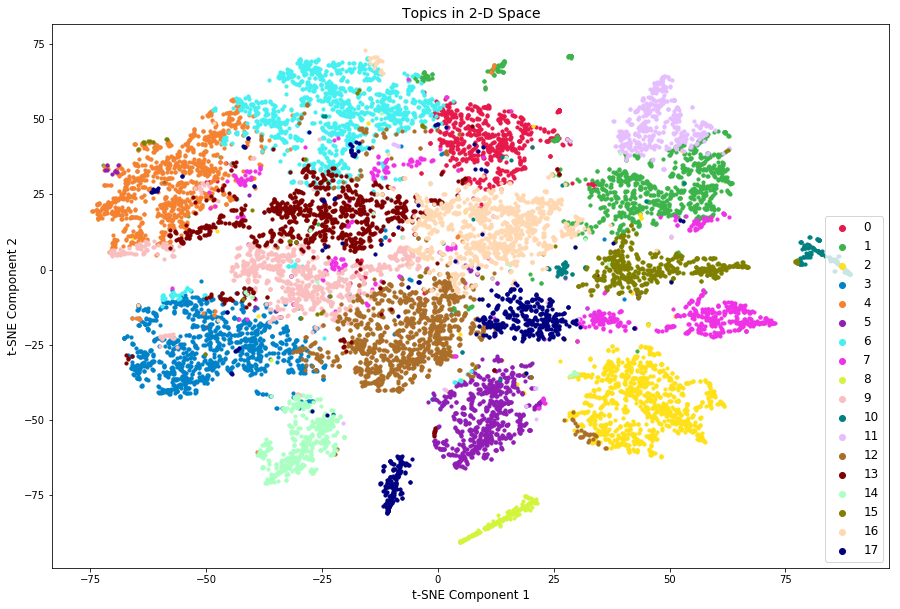

In [180]:
cluster_plot(tsne_data)

## Clustering of NMF-reduced posts

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=18).fit_predict(topics_matrix_filtered)

In [ ]:
kmeans_topic_per_post = [[x] for x in kmeans]
kmeans_tsne_data = np.concatenate((topics_mapped_2d, kmeans_topic_per_post), 1)

## Export topics to app.py

In [29]:
df['topic'] = max_topic_per_post_df

In [30]:
df.shape

(18366, 13)

In [55]:
null_geos.shape

(6480, 13)

In [80]:
# impute geo-coords for data with missing values
import random

city_centers = df.groupby(['city']).mean()[['gmap_lon','gmap_lat']]
null_geos = df[df.gmap_lat.isnull() | df.gmap_lon.isnull()]

filled_geos = []
for city in null_geos.city.unique():
    to_fill = null_geos[null_geos.city == city]
    to_fill.gmap_lat.fillna(city_centers.loc[city].gmap_lat, inplace=True)
    to_fill.gmap_lon.fillna(city_centers.loc[city].gmap_lon, inplace=True)
    filled_geos.append(to_fill)

# add some gaussian noise so they split up on the map
filled_geos = pd.concat(filled_geos)
filled_geos.gmap_lat = filled_geos.gmap_lat.apply(lambda x: x + random.gauss(0,.08))
filled_geos.gmap_lon = filled_geos.gmap_lon.apply(lambda x: x + random.gauss(0,.08))

/home/rjh336/anaconda2/envs/metis/lib/python3.5/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [83]:
null_geos.shape

(6480, 13)

In [84]:
filled_geos.fillna(0)
filled_geos.shape

(6480, 13)

In [85]:
app_df = pd.concat([df.dropna(), filled_geos])
app_df.shape

(18366, 13)

In [86]:
app_df = app_df.reset_index()
app_df['id'] = app_df.index

In [87]:
app_df.id = app_df.id.apply(int)
app_df.title = app_df.title.apply(str)
app_df.topic = app_df.topic.apply(int)
app_df.body = app_df.body.apply(str)
app_df.city = app_df.city.apply(str)
app_df.url = app_df.url.apply(str)

app_df = app_df[['id','title','body','url','topic','city','gmap_lat','gmap_lon']]

In [88]:
app_df.to_json("../data/app_data.json")

## Other visuals

In [382]:
topic_descriptions

{0: 'New\nMusic\nProjects',
 1: 'Studio\nServices',
 2: 'Teachers',
 3: 'Bassists',
 4: 'Drummers',
 5: 'Music\nfor\nYour\nEvent!',
 6: 'Metalheads',
 7: 'Rehearsal\nSpaces',
 8: 'En Espanol',
 9: 'Cover\nBands',
 10: 'Producer/ \nGhostwriter\nAd Spam',
 11: 'Mixing and\nMastering',
 12: 'Guitarists',
 13: 'Classic Rock',
 14: 'Church',
 15: 'Music \nVideos',
 16: 'Singer/ \nSongwriters',
 17: 'Open Mics\nand Jams'}

In [398]:
topic_pcts = df.topic.value_counts().reset_index()
topic_pcts.topic = topic_pcts.topic.apply(lambda x: x/df.shape[0])
topic_pcts['super'] = np.zeros(len(topic_pcts))
topic_pcts['super'] = topic_pcts['index'].apply(lambda x:"svcs" if x in [1,2,5,7,10,11,15] else "musicians")
topic_pcts['super'] = topic_pcts['index'].apply(lambda x:"event" if x in [8,17,14] else x)

In [399]:
topic_pcts.groupby(['super']).sum()

,index,topic
super,,
0,0,0.089894
1,1,0.061745
2,2,0.064739
3,3,0.072199
4,4,0.066318
5,5,0.053577
6,6,0.085157
7,7,0.048786
9,9,0.060057


In [140]:
topic_bar = df.topic.value_counts().reset_index().rename(columns={'index':'Topic', 'topic':'Number of Posts'}).sort_values('Number of Posts', ascending=False)

In [142]:
topic_bar.Topic=topic_bar.Topic.apply(lambda x: topic_descriptions[x])

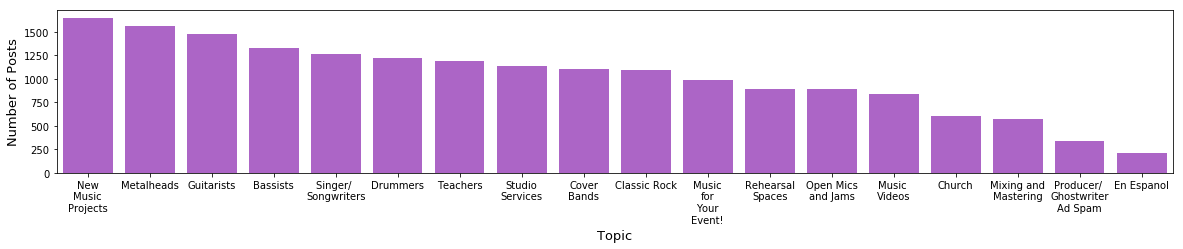

In [146]:
plt.figure(figsize=(20,3))
topicbarchart = sns.barplot('Topic','Number of Posts',data=topic_bar, color="#b355d6")
topicbarchart.set_ylabel('Number of Posts',fontdict={'size':13})
topicbarchart.set_xlabel('Topic',fontdict={'size':13})

In [147]:
topic_dict = []
no_top_words = 10
for topic_idx, topic in enumerate(nmf.components_):
    topwords = [[topic_idx, feature_names[i], topic[i]] for i in topic.argsort()[:-no_top_words - 1:-1]]
    topic_dict += topwords

In [150]:
top_words_df = pd.DataFrame(topic_dict).rename(columns={0:"Topic", 1:"Word", 2:"NMF Weight"})

In [168]:
topic = 17
top_words_df[top_words_df.Topic == topic][['Word','NMF Weight']]

,Word,NMF Weight
170,mic,0.797232
171,open mic,0.796406
172,open,0.775206
173,jam,0.587909
174,pm,0.565864
175,night,0.412448
176,everi,0.197434
177,thursday,0.189214
178,come,0.183834
179,tuesday,0.173868


In [206]:
tsne_df = df.iloc[_idx]
tsne_df['tsne1'] = tsne_data[:,0]
tsne_df['tsne2'] = tsne_data[:,1]
tsne_df['tsne topic'] = tsne_data[:,2]

/home/rjh336/anaconda2/envs/metis/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/rjh336/anaconda2/envs/metis/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/rjh336/anaconda2/envs/metis/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [318]:
x=1
"yes"  "no"

'yes'

In [329]:
def cluster_plot_select(tsne_data, topics, saturate):
    color_map = {0:  '#e6194b', 1:  '#3cb44b', 2:  '#ffe119', 3:  '#0082c8', 4:  '#f58231', 5:  '#911eb4',
                 6:  '#46f0f0', 7:  '#f032e6', 8:  '#d2f53c', 9:  '#fabebe', 10:  '#008080', 11:  '#e6beff',
                 12:  '#aa6e28', 13:  '#800000', 14:  '#aaffc3', 15:  '#808000', 16:  '#ffd8b1', 17:  '#000080',
                 18:  '#808080', 19:  '#000000'}

    plt.figure(figsize=(12, 8))
    for topic in topics:
        inds = np.where(tsne_data[:, 2] == topic)[0]
        plt.scatter(x=tsne_data[inds, 0],
                    y=tsne_data[inds, 1],
                    marker='o',
                    s=10,
                    color=color_map[topic],
                    label=topic,
                    alpha= (1 if topic==saturate else 0.05))

    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.title('Topics in 2-D Space', fontsize=14)
    plt.show()

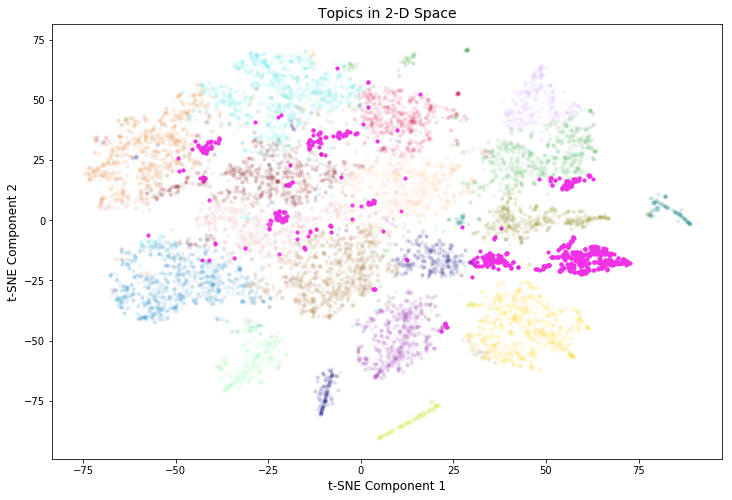

In [357]:
cluster_plot_select(tsne_data, list(range(18)), 7)

In [274]:
# from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

def exploreTSNE(inputdata, topic, west=-75, east=100, north=75, south=-100):
    data = inputdata[inputdata.topic == topic]
    return_df = data[  (data.tsne2 < north) & 
                       (data.tsne2 > south) & 
                       (data.tsne1 < east) & 
                       (data.tsne1 > west)  ]
    print(return_df.shape)
    corpus = " ".join(return_df.prep_body.tolist())
    words = corpus.split()
    counts = Counter(words)
    return return_df, sorted(counts.items(), key=lambda x:x[1], reverse=True)

In [365]:
west = 25
east = 100
north = -3
south = -100
topic_, wc = exploreTSNE(tsne_df, 7, west, east, north, south)

(476, 16)


In [366]:
for i in range(10):
    print(topic_.body.iloc[i],'\n','------------------------')

GUITARIST AVAILABLE 
i'm a 30 year-old musician of 14 years. i play guitar, bass, piano, drums, drum machines, and sing backup vocals. i work in all genres of rock and pop and have tons of studio and live experience.  i'm currently available to record and/or perform. 

you can see some performance clips in the following links: 

https://youtu.be/mbtsgevo3x0 
https://youtu.be/phy-eix86_8 
https://youtu.be/74fylq6sguw 

i'm located in manhattan and have a rehearsal space near times square. i'd love to hear about your project! feel free to contact me with any questions you may have! 
 ------------------------
Great Rehearsal Space now available 
perfect space for small band or solo musician looking for a secure space to make noise.

- lock and key access to a 24hr building.

- room has recording resources to capture rehearsals and demos. 

- drum kit provided - but feel free to bring your own. 

- floor to ceiling windows allow for more natural light than any rehearsal space you've seen.


In [367]:
wc

[('studio', 832),
 ('rehears', 733),
 ('space', 727),
 ('room', 632),
 ('avail', 444),
 ('band', 437),
 ('contact', 355),
 ('hour', 340),
 ('show', 339),
 ('music', 338),
 ('info', 318),
 ('month', 268),
 ('practic', 262),
 ('drum', 243),
 ("'s", 228),
 ('amp', 220),
 ('locat', 216),
 ('rent', 205),
 ('need', 194),
 ('call', 191),
 ('look', 189),
 ('pa', 189),
 ('x', 187),
 ('rental', 186),
 ('sound', 185),
 ('includ', 181),
 ('time', 174),
 ('share', 167),
 ('guitar', 164),
 ('musician', 164),
 ('equip', 154),
 ('monthli', 154),
 ('great', 154),
 ('access', 154),
 ('bass', 153),
 ('record', 148),
 ('free', 141),
 ('pleas', 135),
 ('rate', 132),
 ('one', 130),
 ('also', 127),
 ('play', 127),
 ('full', 126),
 ('day', 125),
 ('want', 124),
 ('•', 124),
 ('per', 123),
 ('week', 121),
 ('book', 120),
 ('lo', 120),
 ('new', 119),
 ('secur', 119),
 ('us', 118),
 ('set', 118),
 ('angel', 118),
 ('gear', 116),
 ('park', 115),
 ('system', 115),
 ('shoot', 114),
 ('open', 113),
 ('larg', 109),
 